In [1]:
#Import necessary Libraries
import os
import cv2
import itertools
import numpy as np
import pandas as pd

test_dir = "/content/drive/MyDrive/test/"
train_dir = "/content/drive/MyDrive/train/"

data = []

In [2]:
# Processes and loads training images and their labels into the data list
for dirtrain in os.listdir(train_dir):
    if dirtrain == ".ipynb_checkpoints":  # Skip the .ipynb_checkpoints folder
        continue
    print(dirtrain)
    for tr in os.listdir(train_dir + dirtrain):
        img = cv2.imread(train_dir + dirtrain + "/" + tr)
        img = cv2.resize(img, (128, 128))  # Resize to 128x128
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        img = img.reshape(128, 128, 1)  # Update shape to 128x128x1

        data.append([img, dirtrain])

MildDemented
NonDemented
VeryMildDemented
ModerateDemented


In [3]:
# Processes and loads test images and their labels into the data list
for dirtest in os.listdir(test_dir):
    if dirtest == ".ipynb_checkpoints":  # Skip the .ipynb_checkpoints folder
        continue
    print(dirtest)
    for ts in os.listdir(test_dir + dirtest):
        img = cv2.imread(test_dir + dirtest + "/" + ts)
        img = cv2.resize(img, (128, 128))  # Resize to 128x128
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        img = img.reshape(128, 128, 1)  # Update shape to 128x128x1

        data.append([img, dirtest])

NonDemented
VeryMildDemented
MildDemented
ModerateDemented


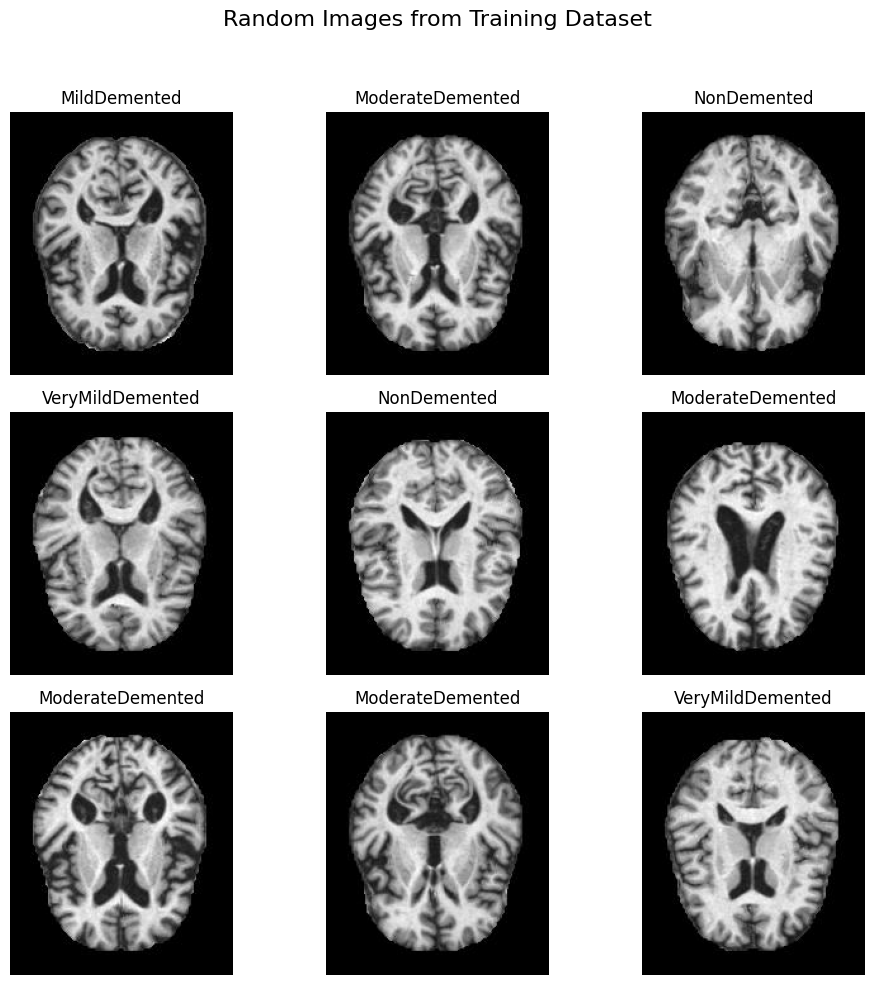

In [4]:
#Visualize the first 9 pitures in train folder
import os
import cv2
import matplotlib.pyplot as plt
from random import choice

def visualize_images(directory, num_images=9):
    """
    Visualizes a grid of random images from the training dataset.

    Args:
    - directory (str): Path to the training dataset.
    - num_images (int): Number of images to display. Should be a perfect square (e.g., 4, 9, 16).
    """
    # Get all class folders, skipping .ipynb_checkpoints and empty folders
    class_folders = [
        os.path.join(directory, folder)
        for folder in os.listdir(directory)
        if os.path.isdir(os.path.join(directory, folder)) and folder != ".ipynb_checkpoints"
    ]

    # Filter out empty folders
    class_folders = [
        folder for folder in class_folders
        if len(os.listdir(folder)) > 0
    ]

    if not class_folders:
        print("No non-empty class folders found.")
        return

    # Prepare the plot
    grid_size = int(num_images**0.5)
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
    fig.suptitle("Random Images from Training Dataset", fontsize=16)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    for ax in axes:
        # Randomly select a non-empty class folder
        selected_class = choice(class_folders)

        # Randomly select an image from the chosen class
        images = [
            img for img in os.listdir(selected_class)
            if not img.startswith('.')  # Skip hidden files like .DS_Store
        ]

        if not images:
            ax.axis('off')  # Skip this plot if no valid images found
            continue

        random_image = choice(images)

        # Load and display the image
        img_path = os.path.join(selected_class, random_image)
        img = cv2.imread(img_path)
        if img is None:
            ax.axis('off')  # Skip this plot if image can't be loaded
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV) to RGB (matplotlib)
        ax.imshow(img)
        ax.axis('off')  # Hide axes
        ax.set_title(os.path.basename(selected_class))  # Display class name

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Directory containing the training dataset
train_dir = "/content/drive/MyDrive/train/"

# Visualize 9 images
visualize_images(train_dir, num_images=9)



In [5]:
#Checking if train dataset is balanced
import os

def check_image_balance(directory):
    """
    Counts the number of images in each class (subdirectory) within the given directory.
    Checks if all classes have an equal number of images.
    """
    image_counts = {}
    for folder in os.listdir(directory):
        if folder == ".ipynb_checkpoints":  # Skip unnecessary folders
            continue
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):  # Ensure it's a directory
            image_counts[folder] = len(os.listdir(folder_path))  # Count files in the directory

    # Display the counts
    for category, count in image_counts.items():
        print(f"Category: {category}, Number of images: {count}")

    # Check for balance
    counts = list(image_counts.values())
    if all(count == counts[0] for count in counts):
        print("\nAll classes have an equal number of images.")
    else:
        print("\nClasses have unequal numbers of images, which could affect the results.")

# Directory containing the test images
train_dir = "/content/drive/MyDrive/train/"

# Check image balance
check_image_balance(train_dir)


Category: MildDemented, Number of images: 717
Category: NonDemented, Number of images: 2570
Category: VeryMildDemented, Number of images: 1792
Category: ModerateDemented, Number of images: 52

Classes have unequal numbers of images, which could affect the results.


Class: NonDemented, Current Count: 2570, Target: 2560
Class: VeryMildDemented, Current Count: 1792, Target: 2560
Class: MildDemented, Current Count: 717, Target: 2560
Class: ModerateDemented, Current Count: 52, Target: 2560
Displaying augmented images for class: MildDemented


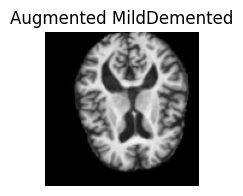

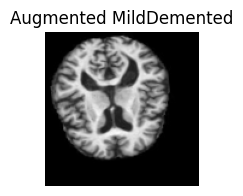

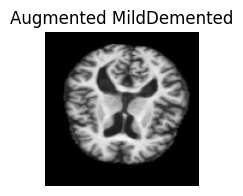

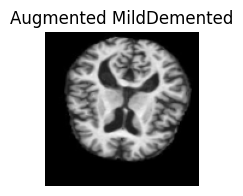

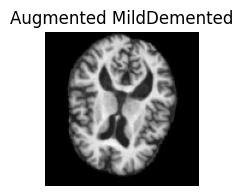

In [6]:
#Augmentation to balance datasets
import os
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

def augment_and_save_to_list_with_resize(train_dir, target_size_dict, num_augmentations=5):
    """
    Resizes images to 128x128, augments them, and saves augmented images to a list (not disk).

    Args:
    - train_dir (str): Path to the training dataset.
    - target_size_dict (dict): Dictionary with class names as keys and target sizes as values.
    - num_augmentations (int): Number of augmented images per original image.

    Returns:
    - augmented_data (dict): Dictionary with class names as keys and lists of augmented images as values.
    """
    # Define augmentation settings
    datagen = ImageDataGenerator(
        rotation_range=15,       # Small rotations
        width_shift_range=0.1,   # Horizontal shifts
        height_shift_range=0.1,  # Vertical shifts
        shear_range=0.1,         # Shearing
        zoom_range=0.1,          # Zoom in/out
        horizontal_flip=True,    # Flipping
        fill_mode='nearest'      # Filling strategy for shifted pixels
    )

    augmented_data = {class_name: [] for class_name in target_size_dict.keys()}  # To store augmented images

    for class_name, target_size in target_size_dict.items():
        class_dir = os.path.join(train_dir, class_name)
        images = os.listdir(class_dir)
        current_count = len(images)

        print(f"Class: {class_name}, Current Count: {current_count}, Target: {target_size}")

        for img_file in images:
            img_path = os.path.join(class_dir, img_file)
            img = cv2.imread(img_path)

            if img is None:
                continue

            # Resize image to 128x128
            img = cv2.resize(img, (128, 128))
            img = img / 255.0  # Normalize pixel values
            img = np.expand_dims(img, axis=0)  # Add batch dimension

            # Generate augmented images
            augmented_images = []
            for i, batch in enumerate(datagen.flow(img, batch_size=1)):
                augmented_images.append(batch[0])  # Append augmented image (already normalized)
                if i >= num_augmentations - 1:
                    break

            # Add augmented images to the list
            augmented_data[class_name].extend(augmented_images)

            # Stop if we’ve reached the target count
            if len(augmented_data[class_name]) + current_count >= target_size:
                break

    return augmented_data

# Directory containing the training dataset
train_dir = "/content/drive/MyDrive/train/"

# Target sizes for each class
target_size_dict = {
    "NonDemented": 2560,
    "VeryMildDemented": 2560,
    "MildDemented": 2560,
    "ModerateDemented": 2560
}

# Augment images and save to a list
augmented_data = augment_and_save_to_list_with_resize(train_dir, target_size_dict)

# Display augmented images
def display_augmented_images(augmented_data, class_name, num_images=5):
    """
    Displays augmented images for a specific class.

    Args:
    - augmented_data (dict): Dictionary with class names and augmented images.
    - class_name (str): Name of the class to display images for.
    - num_images (int): Number of images to display.
    """
    if class_name not in augmented_data:
        print(f"Class {class_name} not found in augmented data.")
        return

    print(f"Displaying augmented images for class: {class_name}")
    for i, img in enumerate(augmented_data[class_name][:num_images]):
        plt.figure(figsize=(2, 2))
        plt.imshow(img)
        plt.title(f"Augmented {class_name}")
        plt.axis('off')
        plt.show()

# Example: Display augmented images for "MildDemented"
display_augmented_images(augmented_data, class_name="MildDemented", num_images=5)


In [7]:
#shuffling and sampling to yield consistent results across multiple runs
import random
random.seed(20)

In [8]:
#Shuffles elements in the list data randomly to avoid bias before splitting into training, validation and test sets
random.shuffle(data)

In [9]:
#seperates data list into two seperate lists: features(x) and labels(y)
x, y = [], []
for e in data:
    x.append(e[0])
    y.append(e[1])

In [10]:
#Converts features(x) and labels(y) into appropriate formats and applies one-hot encoding to labels
from sklearn.preprocessing import OneHotEncoder

x = np.array(x)
y = np.array(y)

# Normalize features (if `x` contains image pixel values)
x = x / 255.0

#Reshape labels for one-hot encoding
y = y.reshape(y.shape[0],1)

#Apply one-hot encoding to the labels
enc = OneHotEncoder(handle_unknown='ignore').fit(y)
print(enc.categories_)
y = enc.transform(y).toarray()
print(f'Data   :   {str(x.shape)}')
print(f'Labels :   {str(y.shape)}')

[array(['MildDemented', 'ModerateDemented', 'NonDemented',
       'VeryMildDemented'], dtype='<U16')]
Data   :   (6430, 128, 128, 1)
Labels :   (6430, 4)


In [11]:
# Split into training, validation, and test sets
from sklearn.model_selection import train_test_split

x_train, x_temp, y_train, y_temp = train_test_split(x, y, random_state=1, test_size=0.3)  # 70% train, 30% temp
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, random_state=1, test_size=0.5)  # 15% val, 15% test

print(f"Training Data   :   {x_train.shape}, Labels: {y_train.shape}")
print(f"Validation Data :   {x_val.shape}, Labels: {y_val.shape}")
print(f"Test Data       :   {x_test.shape}, Labels: {y_test.shape}")

Training Data   :   (4501, 128, 128, 1), Labels: (4501, 4)
Validation Data :   (964, 128, 128, 1), Labels: (964, 4)
Test Data       :   (965, 128, 128, 1), Labels: (965, 4)


In [12]:
#Importing required library
import tensorflow as tf

In [13]:
#configures TensorFlow to optimize how it interacts with available GPU(s)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

model = Sequential([
    Conv2D(64, (4, 4), padding='same', activation='relu', input_shape=(128, 128, 1)),  # Updated input shape
    MaxPooling2D((2, 2), strides=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (2, 2), padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Dropout(0.3),

    Conv2D(256, (2, 2), padding='same', activation='relu'),
    MaxPooling2D((2, 2), strides=(2, 2)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')  # 4 classes
])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
#Detailed summary of Model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 128)         │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 256)           │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 944,452 (3.60 MB)

 Trainable params: 944,452 (3.60 MB)

 Non-trainable params: 0 (0.00 B)

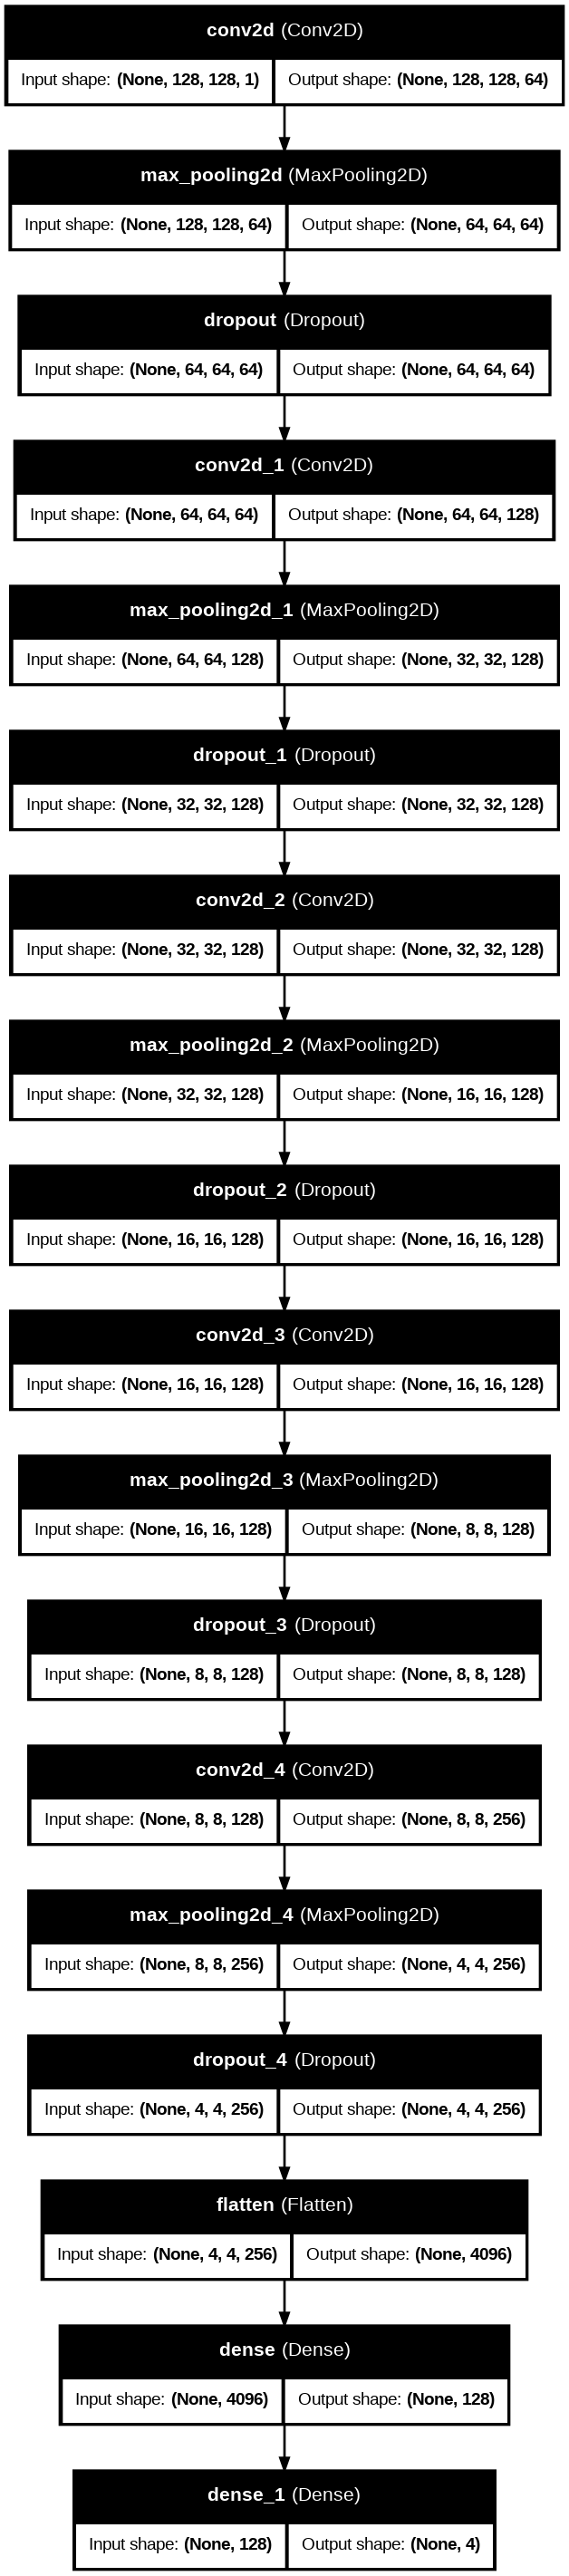

In [16]:
#Visualizes CNN model
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [17]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [18]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitor validation loss
    patience=10,               # Stop after 10 epochs of no improvement
    restore_best_weights=True  # Restore the best weights after stopping
)

# Define the ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',        # Monitor validation loss
    factor=0.5,                # Reduce learning rate by 50%
    patience=5,                # Wait 5 epochs before reducing
    min_lr=1e-6                # Minimum learning rate
)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Train the model
hist = model.fit(
    x_train, y_train,
    epochs=100,
    validation_split=0.2,
    batch_size=64,
    verbose=1,
    shuffle=True,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 27s 259ms/step - accuracy: 0.4722 - loss: 1.0844 - val_accuracy: 0.4628 - val_loss: 1.1325 - learning_rate: 0.0010
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.5026 - loss: 1.0330 - val_accuracy: 0.5372 - val_loss: 1.1455 - learning_rate: 0.0010
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.5252 - loss: 1.0063 - val_accuracy: 0.4817 - val_loss: 1.1004 - learning_rate: 0.0010
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5578 - loss: 0.9238 - val_accuracy: 0.5139 - val_loss: 0.9782 - learning_rate: 0.0010
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.5720 - loss: 0.9331 - val_accuracy: 0.5893 - val_loss: 0.9198 - learning_rate: 0.0010
Epoch 6/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.5795 - loss: 0.8696 - val_accuracy: 0.5893 - val_loss: 0.9427 - learning_rate: 0.0010
Epoch 7/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.6067 - loss: 0.8714

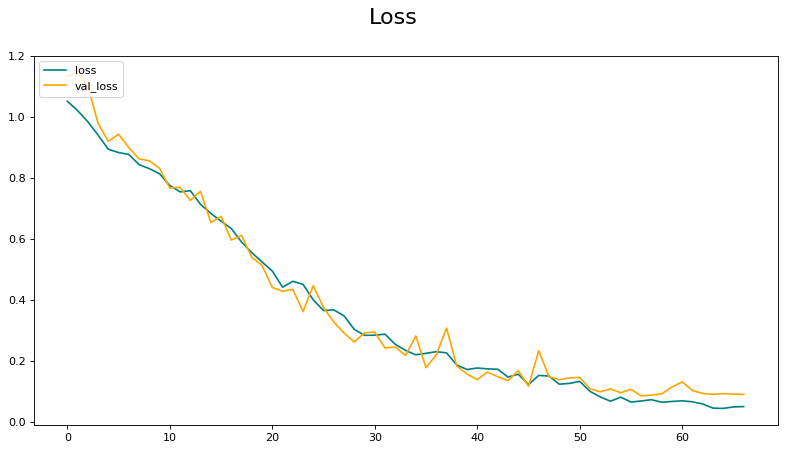

In [20]:
#Visualize loss trend
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig = plt.figure(figsize=(12, 6), dpi=80)
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

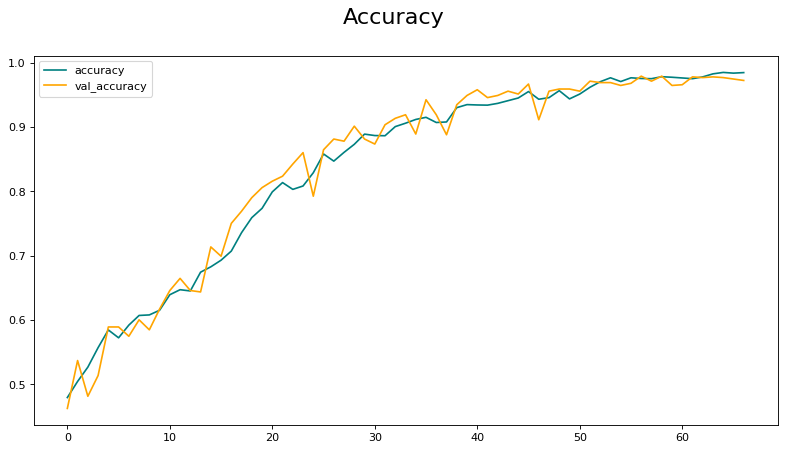

In [21]:
#visualize accuracy trends
fig = plt.figure(figsize=(12, 6), dpi=80)
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [22]:
#Evaluates model's performance

loss_and_metrics = model.evaluate(x_test, y_test, verbose=2)
y_pred = model.predict(x_test).argmax(axis=1)



print(f'Test Loss     : {loss_and_metrics[0]}')
print(f'Test Accuracy : {loss_and_metrics[1]}')
print(y_test.shape, y_pred.shape)

31/31 - 2s - 58ms/step - accuracy: 0.9637 - loss: 0.1301
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Test Loss     : 0.13009513914585114
Test Accuracy : 0.9637305736541748
(965, 4) (965,)


In [24]:
# Evaluate the model's performance
loss_and_metrics = model.evaluate(x_test, y_test, verbose=2)
y_pred = model.predict(x_test).argmax(axis=1)

# Evaluate on training data to get training accuracy
train_loss_and_metrics = model.evaluate(x_train, y_train, verbose=2)

# Evaluate on validation data to get validation accuracy
val_loss_and_metrics = model.evaluate(x_val, y_val, verbose=2)

# Print metrics
print(f'Training Loss     : {train_loss_and_metrics[0]:.4f}')
print(f'Training Accuracy : {train_loss_and_metrics[1] * 100:.2f}%')

print(f'Validation Loss     : {val_loss_and_metrics[0]:.4f}')
print(f'Validation Accuracy : {val_loss_and_metrics[1] * 100:.2f}%')

print(f'Test Loss     : {loss_and_metrics[0]:.4f}')
print(f'Test Accuracy : {loss_and_metrics[1] * 100:.2f}%')

print(f'Prediction Shapes: y_test: {y_test.shape}, y_pred: {y_pred.shape}')


31/31 - 0s - 9ms/step - accuracy: 0.9637 - loss: 0.1301
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
141/141 - 1s - 8ms/step - accuracy: 0.9958 - loss: 0.0212
31/31 - 0s - 8ms/step - accuracy: 0.9533 - loss: 0.2013
Training Loss     : 0.0212
Training Accuracy : 99.58%
Validation Loss     : 0.2013
Validation Accuracy : 95.33%
Test Loss     : 0.1301
Test Accuracy : 96.37%
Prediction Shapes: y_test: (965, 4), y_pred: (965,)


In [25]:
#Visualizes Confusion matrix
from sklearn import metrics

df = pd.DataFrame(
  data = metrics.confusion_matrix(np.argmax(y_test, axis=1), y_pred),
  columns = ['0', '1', '2', '3'],
  index = ['0', '1', '2', '3']
)
df

,0,1,2,3
0,103,0,2,3
1,1,9,0,1
2,2,0,500,16
3,1,0,9,318


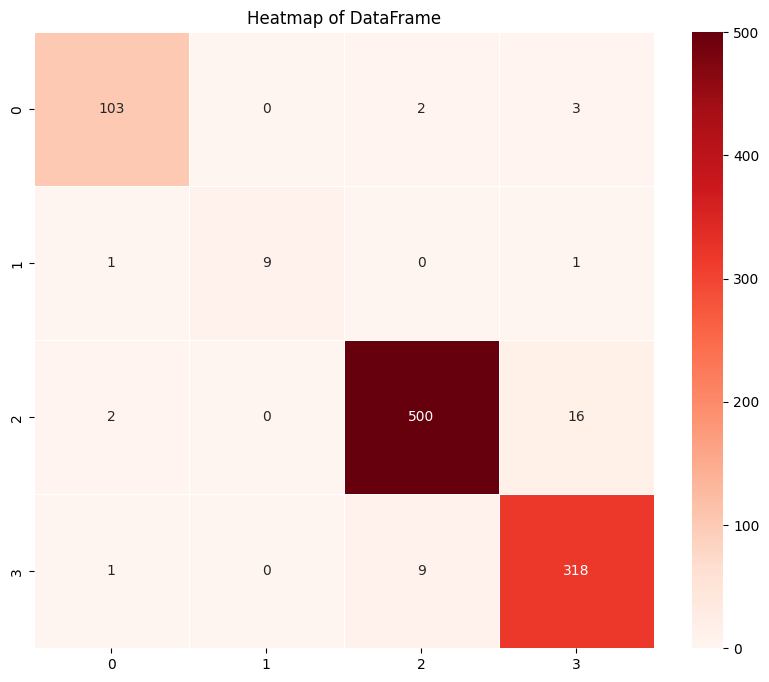

In [26]:
#Visualizes values in the panda dataframe
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df, cmap="Reds", annot=True, fmt='.0f', linewidths=0.5, linecolor='white')
plt.title('Heatmap of DataFrame')
plt.show()

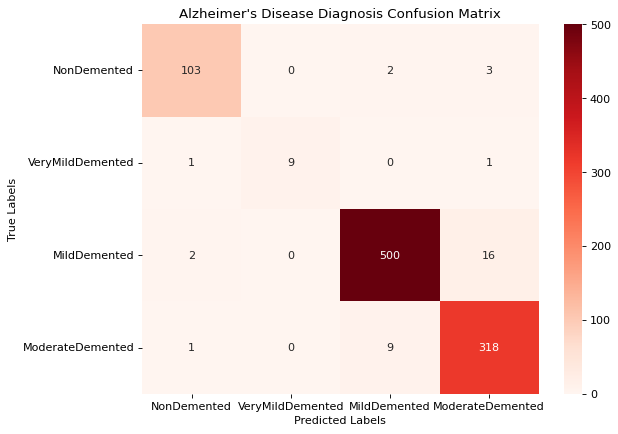

In [32]:
#Visualizes Values in the dataframe
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming CLASSES are defined based on your labels
CLASSES = ["NonDemented", "VeryMildDemented", "MildDemented", "ModerateDemented"]

# Generate predicted labels
pred_ls = y_pred  # y_pred already contains predicted classes in your model
test_ls = np.argmax(y_test, axis=1)  # Convert one-hot encoded test labels to integer labels

# Compute the confusion matrix
conf_arr = confusion_matrix(test_ls, pred_ls)

# Plot the confusion matrix
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Reds', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [27]:
from sklearn.metrics import classification_report

print(classification_report(np.argmax(y_test, axis=1), y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96       108
           1       1.00      0.82      0.90        11
           2       0.98      0.97      0.97       518
           3       0.94      0.97      0.95       328

    accuracy                           0.96       965
   macro avg       0.97      0.93      0.95       965
weighted avg       0.96      0.96      0.96       965



In [33]:
# Save the trained model
model.save('alzheimers_detection_model2.h5')

print("Model saved successfully as 'alzheimers_detection_model2.h5'")


Model saved successfully as 'alzheimers_detection_model2.h5'
